## Determining new oil well locations
___
For this project, oil field conditions will be analyzed in order to predict the best sites for new wells. Oil well parameters and oil well volumes have been collected for three areas of interest.

To prepare the data for the modeling stage, techniques like scaling and encoding will be considered. In order to determine which location is best suited for further well development, we will withold a portion of data to test or validate the models initial findings. We have been instructed to only use linear regression for this task. Tuning Linear Regression to fit the data it is fed. The premier location for new oil wells will have the highest estimated oil reserves. 

Tuning parameters for Linear Regression mainly come down to if all features will be used (l2/ ridge) with varying weight or feature importance (alpha), or if some features are dropped completely (l1 / Lasso).

Once location predictions have been made, the 500 sites with the highest reserve predictions will then be assessed for potential profit margin. Then 200 site predictions will be used for profit calculations. Our development budget for 200 wells is $100million and the revenue from a single barrel of oil is $4.50. From there a single region will be selected to move forward, analyzing potential profits and risks using bootstrapping techniques, or synthetic data derrived from the real data, to create confidence intervals for each region. Any region with less than 2.5% risk of losing money will be considered for development. If multiple options exist the location with the highest average profit will be developed.

Our data has the format of:
id — unique oil well identifier
f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
product — volume of reserves in the oil well (thousand barrels).

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from matplotlib import pyplot as plt

In [2]:
# load all the data
data_one = pd.read_csv('geo_data_0.csv')
data_two = pd.read_csv('geo_data_1.csv')
data_three = pd.read_csv('geo_data_2.csv')

# dfs is a list of our dataframes
dfs = [data_one, data_two, data_three]

In [3]:
# explore the data to provide the next steps
for d in dfs:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

thoughts
___
Our data is all numeric

In [4]:
# a more in depth view of the numeric categories
for d in dfs:
    print(d.describe())

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%       

thoughts
___
from .info()
- zero missing values, and column data types match across all datasets
- id column (from documentation) is a unique well identifier 
- product is our target column

from .describe()
- location 3 has the most oil, highest 25%, 50%, 75%, max
- each location is different. originally I thought to merge all data and construct the model, I now see that will just add noise to the data.
- will need to scale, no need for encoding

In [5]:
# check for duplicates
for d in dfs:
    print(d.duplicated().sum())

0
0
0


thoughts
___
No duplicates, which is great! the data is anonymous, but there is a well id that should be unique 


We know some financial parameters about our business problem. We have our budget, our development strategy, our product sale price, and our target variable. What is our breakeven point for the target oil reserves?

In [6]:
# calculate the breakeven point
budget = 100000000
wells = 200
barrel_revenue = 4.5
break_even = (budget / wells) / barrel_revenue
print(f"{break_even} barrels needed to breakeven")

111111.11111111111 barrels needed to breakeven


____
#### Feature distributions
____
- what are their distributions?
- how much do they vary?


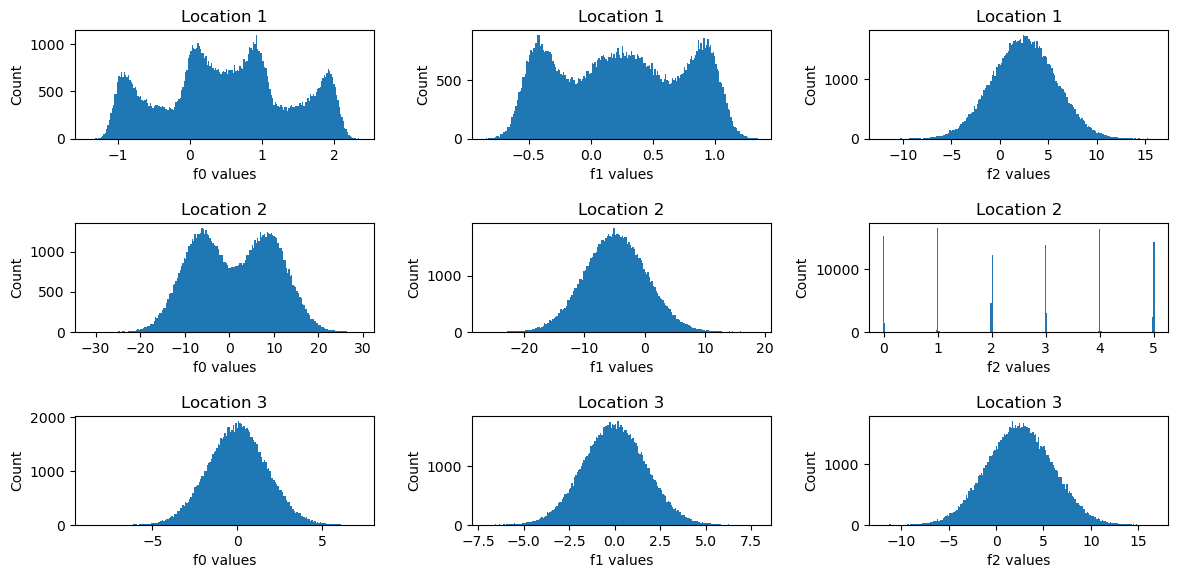

In [7]:
# plot distributions of location variables

# all 3 dataframes and all 3 features
location = ['Location 1', 'Location 2', 'Location 3']
columns = ['f0', 'f1', 'f2']

# Using subplot() to display all charts together
plt.figure(figsize=(12, 6))
counter = 0
for data_index, data in enumerate(dfs):
    for col in columns:
        counter += 1
        plt.subplot(3, 3, counter)
        plt.hist(data[col], bins=200)
        plt.xlabel(f"{col} values")
        plt.ylabel('Count')
        plt.title(location[data_index])

plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=1.5)
plt.show()

thoughts
___
feature 0: 
- data_one is multimodal centered on 0.5
- data_two is bimodal centered on 0
- data_three is normal centered on 0

feature 1:
- data_one is multimodal centered on 0.25
- data_two is normal centered on ~ -5
- data_three is normal centered on 0

feature 2:
- data_one normal centered on 2.5
- data_two distinct values 0-5
- data_three noraml centered on 2.5 slightly wider than data_one.f2

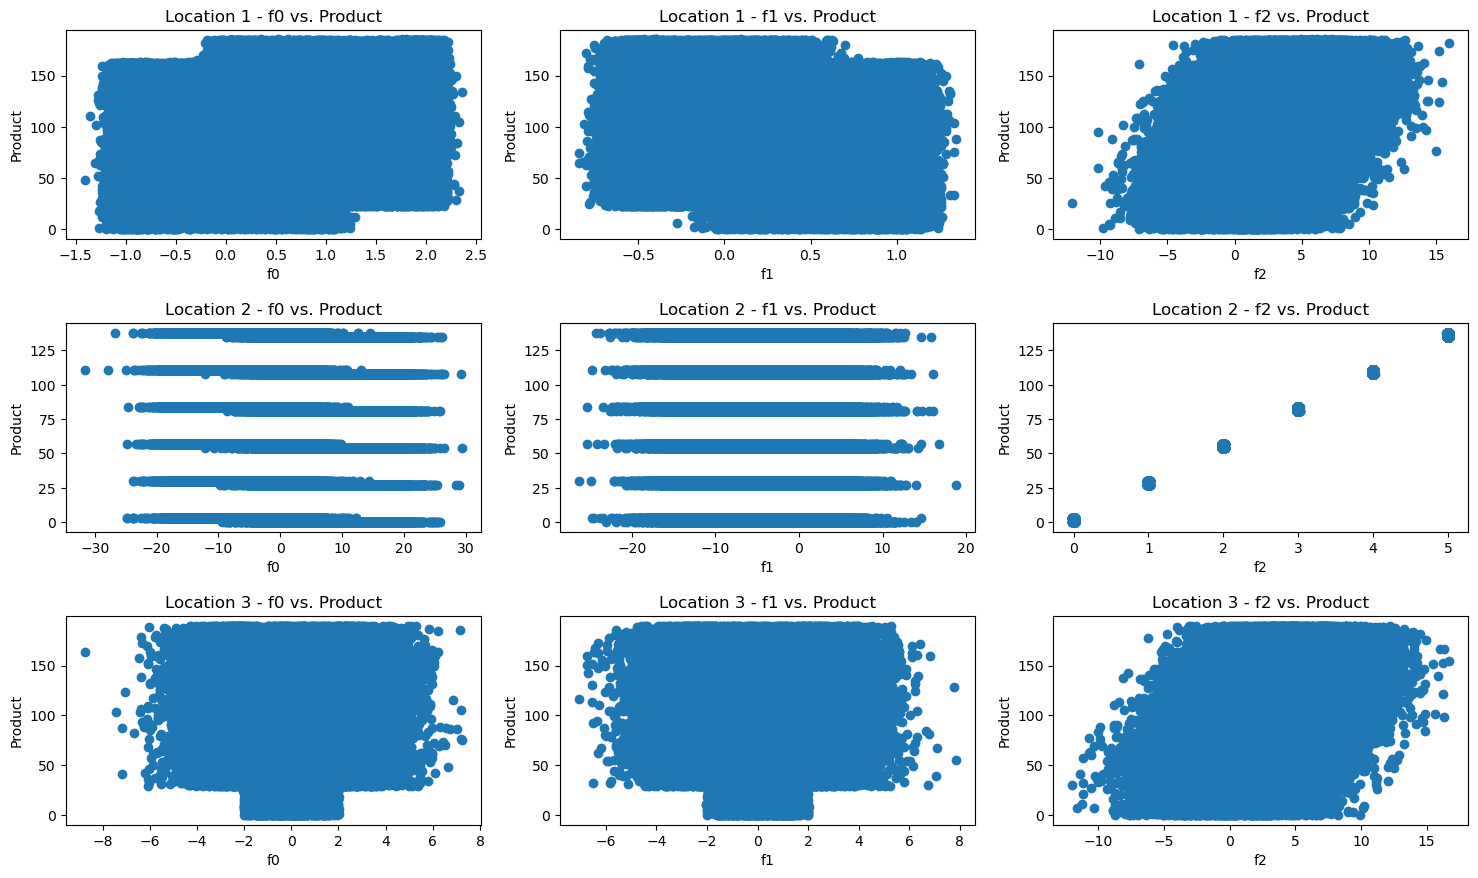

In [8]:
# now the features vs the target
plt.figure(figsize=(15, 9))
counter = 0

for data_index, data in enumerate(dfs):
    for col in columns:
        counter += 1
        plt.subplot(3, 3, counter)
        plt.scatter(data[col], data['product'])
        plt.xlabel(col)
        plt.ylabel('Product')
        plt.title(f"{location[data_index]} - {col} vs. Product")

plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=1.5)
plt.show()

thoughts
___
Most of these provide no no real trends. f2 appears to be the most important feature. 

location 2, f2 provides the answer to where the oil is.

In [9]:
# what is going on with data_two.f2?
data_two['f2'].value_counts()

f2
-0.005876    1
 4.007133    1
 3.002704    1
 1.995378    1
 1.004327    1
            ..
 3.009891    1
 2.000013    1
 0.017600    1
 4.007500    1
-0.003299    1
Name: count, Length: 100000, dtype: int64

thoughts
___
nearly distinct values

____
#### Modeling
___
Construct a function to make predictions for our locations

In [10]:
results_dict = {}


def location_selecter(df):
    """
    This function: train test splits the data, scales features with standard scaler, 
    using cross validation to estimate linear regressions ability to describe the data.
    Displays the results/ scores from cross validation, then uses the model to predict oil reserves for 
    the test sets. Test set results are then stored in the global dictionary.

    Args:
        df: a list of dataframes
    """
    # prepare data for modeling
    counter = 0

    # loop through data
    for data in df:
        counter += 1

        print(f"Location: {counter}")
        print()
        # split data into features and target
        X = data.drop(['id', 'product'], axis=1)
        y = data['product']

        # train-test-split to create a portion of data that is hidden, to evaluate the model, and reduce over fitting
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=17)

        # scale the features
        scaler_x = StandardScaler()
        X_train_scaled = scaler_x.fit_transform(X_train)
        X_test_scaled = scaler_x.transform(X_test)

        # initalize the models for linear regression
        model = LinearRegression()

        # cross-validation with R2 and RMSE, estimating testing results
        # scoring metrics
        scoring = ['r2', 'neg_root_mean_squared_error']
        scores = cross_validate(model, X_train_scaled, y_train,
                                cv=10, scoring=scoring, return_train_score=False)

        # analyze scores of cross validation on training sets
        print("R2 scores:", scores['test_r2'])
        print()
        print("Mean R2:", scores['test_r2'].mean())
        print()

        # convert to positive RMSE
        rmse_scores = -scores['test_neg_root_mean_squared_error']
        print("RMSE scores:", rmse_scores)
        print()
        print("Mean RMSE:", rmse_scores.mean())
        print()

        # fit the models
        model.fit(X_train_scaled, y_train)

        # predict
        model_predict = model.predict(X_test_scaled)

        # evaluate the predictions
        rmse_model = root_mean_squared_error(y_test, model_predict)

        r2_model = r2_score(y_test, model_predict)

        # print metrics
        print("Test set results")
        print(f"  RMSE: {rmse_model}")
        print(f"  R-squared: {r2_model}")

        # unscale the predictions
        print(
            f"average oil reserve volume prediction is {model_predict.mean():.3f} thousand barrels")
        print(
            f"Actual average oil reserve {y_test.mean():.3f} thousand barrels")
        print()

        # store results
        results_dict[counter] = {
            'predict': pd.Series(model_predict, index=y_test.index),
            'y_train': y_train,
            'y_test': y_test,
            'X_test': X_test_scaled,
            'X_train': X_train_scaled,
            'slope': model.coef_,
            'intercept': model.intercept_
        }

In [11]:
# run the function
location_selecter(dfs)

Location: 1

R2 scores: [0.27115139 0.29305246 0.28402685 0.28089756 0.25895116 0.25747544
 0.27577863 0.28417134 0.27119412 0.28749105]

Mean R2: 0.2764189995256123

RMSE scores: [37.62559509 37.20952072 37.40603744 37.68207366 38.0124348  37.8662079
 37.31929364 37.91009406 38.14108949 37.44563487]

Mean RMSE: 37.66179816620397

Test set results
  RMSE: 37.785995976559214
  R-squared: 0.27295312848785325
average oil reserve volume prediction is 92.391 thousand barrels
Actual average oil reserve 92.832 thousand barrels

Location: 2

R2 scores: [0.99962685 0.99962589 0.99961547 0.99962035 0.99962314 0.99963018
 0.99962676 0.99962502 0.99962758 0.99961962]

Mean R2: 0.9996240842765365

RMSE scores: [0.88907657 0.88243863 0.89536632 0.89887318 0.89842512 0.88781552
 0.88759553 0.8933788  0.88702583 0.89600182]

Mean RMSE: 0.8915997319542293

Test set results
  RMSE: 0.8867650608506769
  R-squared: 0.9996252665652758
average oil reserve volume prediction is 68.819 thousand barrels
Actual 

thoughts
___
Location 1 and 3 are not well fit models. Average r2 scores of: 0.273, 0.199 respectfully

Location 2 is essentially perfect. All of this follows the distribiution plots.

In [12]:
# what are the top 500 predictions?

for i in range(1, 4):
    # store the 500 top predictions
    largest_predicted = results_dict[i]['predict'].nlargest(500)

    # match those indices to actual values
    matched_actual_values = results_dict[i]['y_test'].loc[largest_predicted.index]

    # store, actual and predicted average reserve to compare
    predict_average = largest_predicted.sum() / 500
    matched_actual_average = matched_actual_values.sum() / 500

    print(
        f"location {i}: \n"
        f"500 largest predicted reserves\n"
        f"{largest_predicted}\n"
        f"predict average: {predict_average:.2f}\n"
        f"matched actual average: {matched_actual_average:.2f}"
    )
    print()

location 1: 
500 largest predicted reserves
16373    175.582840
65743    172.763442
99628    172.612457
57591    170.341240
29826    169.791228
            ...    
74872    139.860546
17162    139.846629
57519    139.819676
13354    139.815589
14994    139.809902
Length: 500, dtype: float64
predict average: 147.62
matched actual average: 142.51

location 2: 
500 largest predicted reserves
80439    139.988254
55165    139.905759
42738    139.852962
38665    139.818578
20191    139.779046
            ...    
44152    137.990775
157      137.988185
7697     137.987613
13858    137.985636
64549    137.982186
Length: 500, dtype: float64
predict average: 138.41
matched actual average: 137.95

location 3: 
500 largest predicted reserves
69502    174.290157
41820    172.021003
54085    165.684673
82661    164.085488
17415    162.823339
            ...    
8612     136.026169
56801    136.021009
14240    136.019810
23474    136.008162
83472    136.000972
Length: 500, dtype: float64
predict aver

thoughts
___
location 1
- poorly fit model r2 0.273 (rounded)
- accurately obtained the average reserve, difference of 441 barrels
- average error (rmse) 37,786 barrels
- predicted average of all wells 92,391 barrels
- top 500 predicted wells 147,616 barrels
- actual value: 142.51

location 2
- perfectly fit model r2 0.9996
- accurate average, difference 8 barrels
- average error (rmse) 887 barrels
- predicted average 68,819 barrles
- top 500 predicted wells 138,411 barrels
- actual value: 137.95

location 3
- worst fit model r2 0.198 (rounded)
- accurate average difference of 737 barrels
- average error (rmse) 40,140 barrels
- predicted average 95,086 barrels
- top 500 predicted wells 143,227 barrels
- actual value: 134.80

Somehow the average was accurate for all locations. Location 2 is very accurate in it's ability to predict reserves, unfortunately it accurately says there is less oil there.

All three locations have more actual and predicted oil reserves than the breakeven amount.


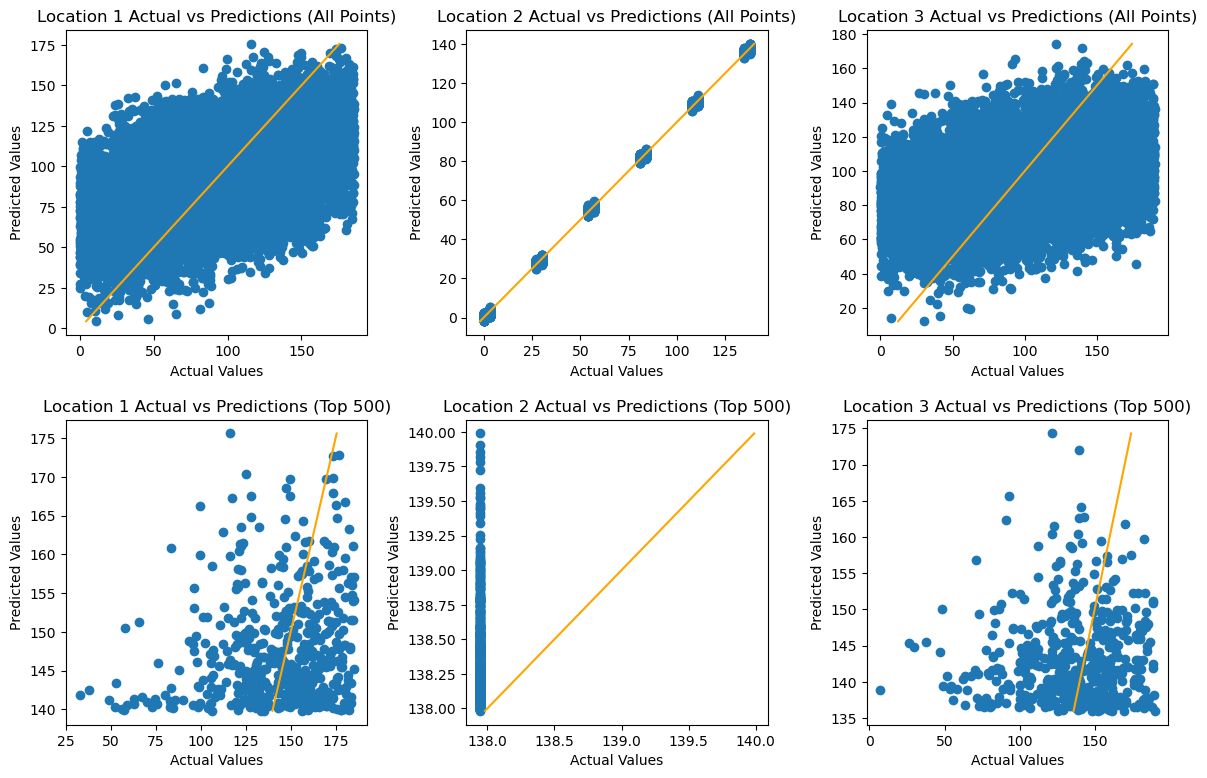

In [13]:
# how do the predictions relate the actual values.
# all predictions, top 500 predictions, top 200 predictions

plt.figure(figsize=(12, 8))  # Adjust figsize for two rows of subplots

for i in range(1, 4):
    # all points
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, subplot index 1, 2, 3
    plt.scatter(x=results_dict[i]['y_test'], y=results_dict[i]['predict'])
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Location {i} Actual vs Predictions (All Points)")
    plt.plot([min(results_dict[i]['predict']), max(results_dict[i]['predict'])], [
             min(results_dict[i]['predict']), max(results_dict[i]['predict'])], color='orange')

    # top 500 points
    plt.subplot(2, 3, i + 3)  # 2 rows, 3 columns, subplot index 4, 5, 6
    top_500_predict = results_dict[i]['predict'].nlargest(500)
    top_500_actual = results_dict[i]['y_test'].loc[top_500_predict.index]
    plt.scatter(x=top_500_actual, y=top_500_predict)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Location {i} Actual vs Predictions (Top 500)")
    plt.plot([min(top_500_predict), max(top_500_predict)], [
             min(top_500_predict), max(top_500_predict)], color='orange')


plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=1.5)
plt.show()

thoughts
___
500 plots are basically zooming in on all predictions. The spread of actual values is concerning for locations 1, 3. Location 2 all have the same reserve level.

____
#### Profit calculations
____

thoughts
___
All three location's top 500 prediction averages are above the breakeven point and have the ability to create profit

In [14]:
# revenue function
def revenue(target_test, predictions, count):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target_test[pred_sorted.index][:count]
    return 4500 * selected.sum()

In [26]:
# bootstrap 1000 times over the 500 best sites with replacement
# each bootstrap is taking 200 samples which will be averaged
# this average is then confidence intervaled at lower limit of 2.5%
# if this number is greater than the breakeven point, the site is considered a good decision. ultimately choose the best
state = np.random.RandomState(124)
for i in range(1, 4):
    values = []
    for samp in range(1000):
        target_subsample = results_dict[i]['y_test'].sample(
            500, replace=True, random_state=state)
        probs_subsample = results_dict[i]['predict'][target_subsample.index]

        values.append(revenue(target_subsample, probs_subsample, 200))

    values = pd.Series(values)
    lower = values.quantile(0.025)  # lower bound (2.5% quantile)
    upper = values.quantile(0.975)  # upper bound (97.5% quantile)

    # distribution stats
    mean = values.mean()
    std = values.std()
    z_score = ((budget - mean) / std)

    print(f"Location {i}")
    print("Average revenue:", mean)
    print(f"95% Confidence Interval: ({lower:.2f}, {upper:.2f})")
    print("Estimated average profit:", mean - budget)
    print("Estimated profit at lower limit:", lower - budget)
    print(f"Breakeven point has a z-score of {z_score:.2f}.")
    print()

Location 1
Average revenue: 104685779.4751205
95% Confidence Interval: (99249940.72, 110007014.71)
Estimated average profit: 4685779.4751205
Estimated profit at lower limit: -750059.2802912742
Breakeven point has a z-score of -1.70.

Location 2
Average revenue: 104878630.57235394
95% Confidence Interval: (100875922.65, 109087746.77)
Estimated average profit: 4878630.572353944
Estimated profit at lower limit: 875922.6515690684
Breakeven point has a z-score of -2.30.

Location 3
Average revenue: 103550141.45626234
95% Confidence Interval: (98390340.12, 108912171.32)
Estimated average profit: 3550141.456262335
Estimated profit at lower limit: -1609659.8829932958
Breakeven point has a z-score of -1.28.



In [24]:
# location 2 is the only one with a profit

# what is the risk associated with location 2?
values = []
for samp in range(1000):
    target_subsample = results_dict[2]['y_test'].sample(
        500, replace=True, random_state=state)
    probs_subsample = results_dict[2]['predict'][target_subsample.index]

    values.append(revenue(target_subsample, probs_subsample, 200))

values = pd.Series(values)

# amount of values below breakeven
count_below = (values < budget).sum()
total_count = len(values)
percentile = (count_below / total_count) * 100

print(
    f"The budget value (${budget}) is at the {percentile:.2f}th percentile of the bootstrapped revenue distribution.")

The budget value ($100000000) is at the 1.00th percentile of the bootstrapped revenue distribution.


#### Conclusion
____
Location 2 is the only location worth considering. It met the criteria for development, there is less than a 1% chance to lose money on this investment. Average estimated profit for this location is $4.9 million.  

Business situation: I think there are much better ways to use $100 million than to hope you make the average of $4million. A situation to do it, is if you have lots of employees that count on work to do. Profit is profit. It was unclear if the $100 million investment included all costs and taxes associated with mining oil. If not then this is unlikely to be profitable opportunity.

Future possibilities: The other two locations had more oil but the data was not explained through linear regression. If running other models, finding additional data is in the budget then it could be a consideration.  Improving the predictions in the other locations could elevate the estimate profit above the breakeven point even more then location 2.